In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/framingham/framingham.csv


In [3]:
# Importing all the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from sklearn.metrics import roc_curve, auc
from abc import ABC,abstractmethod
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [4]:
#Reading the dataset that we added
dataSet = df=pd.read_csv(r"../input/framingham/framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
#Description of the DataFrame
dataSet.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [6]:
#Feature Selection (Correlation Coefficient)
standardCorrelation = dataSet.corr()
print(standardCorrelation['TenYearCHD'].sort_values(ascending = False))

TenYearCHD         1.000000
age                0.225256
sysBP              0.216429
prevalentHyp       0.177603
diaBP              0.145299
glucose            0.125544
diabetes           0.097317
male               0.088428
BPMeds             0.087489
totChol            0.082184
BMI                0.075192
prevalentStroke    0.061810
cigsPerDay         0.057884
heartRate          0.022913
currentSmoker      0.019456
education         -0.054059
Name: TenYearCHD, dtype: float64


In [7]:
#Removing unimportant features and splitting the data into X and y
X=dataSet.drop(['education','TenYearCHD'], axis=1) 
y=dataSet['TenYearCHD']

In [8]:
#Check the empty values in each column
X.isna().any()

male               False
age                False
currentSmoker      False
cigsPerDay          True
BPMeds              True
prevalentStroke    False
prevalentHyp       False
diabetes           False
totChol             True
sysBP              False
diaBP              False
BMI                 True
heartRate           True
glucose             True
dtype: bool

In [9]:
#Check the count of empty values in each column
X.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
dtype: int64

In [10]:
#Replace all the missing values with mean and store it in X_clean
X_clean=X
from sklearn.impute import SimpleImputer
si=SimpleImputer(strategy='most_frequent')
si.fit(X[['BPMeds']])
pd.DataFrame(si.transform(X[['BPMeds']]))
si2=SimpleImputer(strategy='median')
si2.fit(X)
X_clean=pd.DataFrame(si2.transform(X_clean))

In [11]:
X_clean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0
1,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0
2,1.0,48.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0
3,0.0,61.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0
4,0.0,46.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0


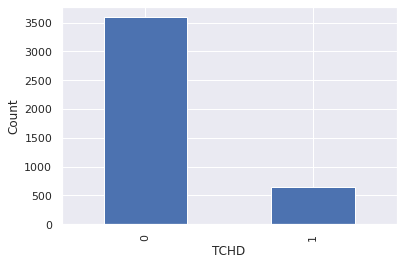

In [12]:
#Check if the target class is imbalanced
sns.set()
TenYearchd_plot= dataSet['TenYearCHD'].value_counts().plot(kind='bar')
plt.xlabel('TCHD')
plt.ylabel('Count')
plt.show()


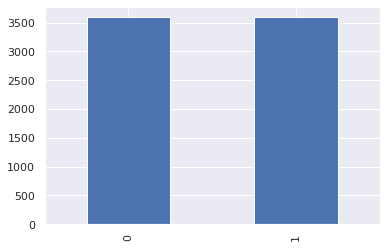

In [13]:

#Balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_clean, y = sm.fit_resample(X_clean, y)
balCHDPlot=y.value_counts().plot(kind='bar')
plt.show()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_clean,y,test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [14]:
#Scale the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=pd.DataFrame(sc.fit_transform(X_train))
X_test=pd.DataFrame(sc.transform(X_test))
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.103497,0.164187,-1.027196,-0.783391,-0.232123,-0.112938,-0.820301,-0.192253,-0.448653,-0.407359,-0.697187,-0.497257,-0.075042,-0.335913
1,-1.028163,-1.278125,-1.027196,-0.783391,-0.232123,-0.112938,-0.820301,-0.192253,-0.808358,-0.322636,0.111441,-1.427565,-1.395525,-0.480777
2,1.103497,0.164187,1.039200,2.794604,-0.232123,-0.112938,-0.820301,-0.192253,-0.448653,-0.746252,-0.778049,0.029482,0.541183,-0.589425
3,-1.028163,2.207462,-1.027196,-0.783391,-0.232123,11.217790,1.310496,-0.192253,-2.989069,0.270426,0.677480,-0.201130,-0.691267,-0.770505
4,1.103497,-1.053859,1.039200,2.433385,-0.232123,-0.112938,-0.820301,-0.192253,-0.334869,-1.378712,-1.972013,-0.031059,1.186410,-0.567569


In [15]:
#Re-assign the columns
X_train.columns= X.columns   
X_test.columns= X.columns

y_train.index= X_train.index
y_test.index= X_test.index

In [16]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _is_finished(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False
    
    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])
        return entropy

    def _create_split(self, X, thresh):
        left_idx = np.argwhere(X <= thresh).flatten()
        right_idx = np.argwhere(X > thresh).flatten()
        return left_idx, right_idx

    def _information_gain(self, X, y, thresh):
        parent_loss = self._entropy(y)
        left_idx, right_idx = self._create_split(X, thresh)
        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0: 
            return 0
        
        child_loss = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
        return parent_loss - child_loss

    def _best_split(self, X, y, features):
        split = {'score':- 1, 'feat': None, 'thresh': None}

        for feat in features:
            X_feat = X[:, feat]
            thresholds = np.unique(X_feat)
            for thresh in thresholds:
                score = self._information_gain(X_feat, y, thresh)

                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['thresh'] = thresh

        return split['feat'], split['thresh']
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # stopping criteria
        if self._is_finished(depth):
            most_common_Label = np.argmax(np.bincount(y))
            return Node(value=most_common_Label)

        # get best split
        rnd_feats = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, rnd_feats)

        # grow children recursively
        left_idx, right_idx = self._create_split(X[:, best_feat], best_thresh)
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_thresh, left_child, right_child)
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [17]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)
def accuracy(y_true, y_pred):   
    accuracy = np.sum(y_true == y_pred)/len(y_true)   
    return accuracy

In [18]:
#Defining a function to visualize the confusion matrix
def plot_confusion_matrix(y_test, y_pred, plt_title):
    c_m=confusion_matrix(y_test, y_pred)
    print("\u0332".join('\nClassification Report for the main implementation\n'),'\n', classification_report(y_test, y_pred))
    sns.heatmap(c_m, fmt='g', annot=True, cmap='BuPu')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return c_m

In [19]:
#Defining a function to plot the ROC curve
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict(np.squeeze(np.asarray(X.iloc[index])))
    fpr, tpr, thresholds = roc_curve(np.squeeze(np.asarray(y.iloc[index])), y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [20]:
#Remove all the single-dimensional entries 
x = np.squeeze(np.asarray(X_train))
y = np.squeeze(np.asarray(y_train))
X_test  = np.squeeze(np.asarray(X_test))
y_test = np.squeeze(np.asarray(y_test))

In [21]:
clf = RandomForest(n_trees = 3)
clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test) 
acc1 = accuracy(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print("Accuracy: ", acc1)
print("RMSE: ", rmse   )

Accuracy:  0.825452016689847
RMSE:  0.17454798331015298


In [22]:
#Converting y into a dataframe and removing the extra rows
y = pd.DataFrame(y)
y = y.iloc[: 4238]


̲C̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n̲ ̲R̲e̲p̲o̲r̲t̲ ̲f̲o̲r̲ ̲t̲h̲e̲ ̲m̲a̲i̲n̲ ̲i̲m̲p̲l̲e̲m̲e̲n̲t̲a̲t̲i̲o̲n̲
 
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       707
           1       0.85      0.80      0.82       731

    accuracy                           0.83      1438
   macro avg       0.83      0.83      0.83      1438
weighted avg       0.83      0.83      0.83      1438



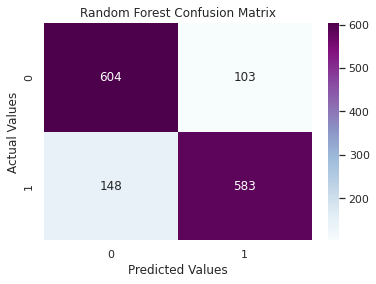

In [23]:
cm_rfc= plot_confusion_matrix(y_test, y_pred, 'Random Forest Confusion Matrix')

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
kf =KFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 3390, Test set:848
Fold:2, Train set: 3390, Test set:848
Fold:3, Train set: 3390, Test set:848
Fold:4, Train set: 3391, Test set:847
Fold:5, Train set: 3391, Test set:847


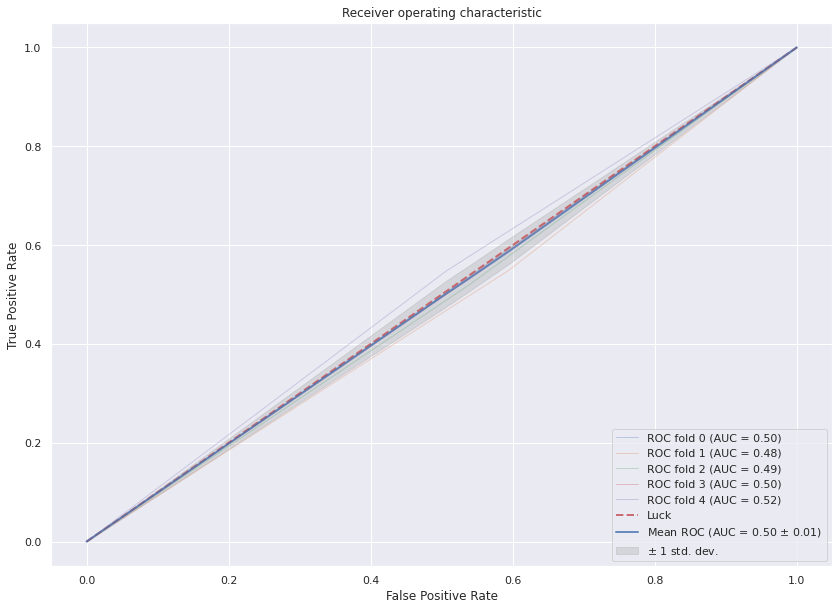

,AUC Train,AUC Test
0,0.857108,0.498671
1,0.857399,0.477255
2,0.867504,0.490432
3,0.864022,0.496967
4,0.857437,0.520563


In [25]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X,y), range(5)):
    clf.fit(np.squeeze(np.asarray(X.iloc[train])), np.squeeze(np.asarray(y.iloc[train])))
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])